In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import glob

In [2]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

In [3]:
plt.style.use('style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
Directory = '20220210'
Date = '2022-02-10'

In [5]:
File = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/RGAScan_{}.h5'.format(Directory, Date)
rga_scans = np.array(pd.read_hdf(File, key='rga/rga'))
rga_timestamps = np.array(pd.read_hdf(File, key='rga/timestamp'))
amu = np.arange(1,100.01,0.1)
delta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in rga_timestamps])

In [6]:
TempFile = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Temps_{}.h5'.format(Directory, Date)
temp = np.array(pd.read_hdf(TempFile, key='omega/omega'))
temp_timestamps = np.array(pd.read_hdf(TempFile, key='omega/timestamp'))
tempdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in temp_timestamps])

In [7]:
PressFile = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Pressure_{}.h5'.format(Directory, Date)
press = np.array(pd.read_hdf(PressFile, key='ed/ed'))
press_timestamps = np.array(pd.read_hdf(PressFile, key='ed/timestamp'))
pressdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in press_timestamps])
# pressdelta_t = np.array([(x-pressdelta_t[0]).total_seconds() for x in pressdelta_t])

In [8]:
TECFile = glob.glob('/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/TEC_*.h5'.format(Directory))
TECFile.sort()
tec = np.empty(4, dtype='object')
tec_timestamps = np.empty(4, dtype='object')
for i, file in enumerate(TECFile):
    tec[i] =  np.array(pd.read_hdf(file, key='tec/tec'))
    tec_timestamps[i] = np.array(pd.read_hdf(file, key='tec/timestamp'))
tec = np.vstack(tec)
tec_timestamps = np.concatenate((tec_timestamps[0], tec_timestamps[1], tec_timestamps[2], tec_timestamps[3]))
tecdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in tec_timestamps])
# tecdelta_t = np.array([(x-tecdelta_t[0]).total_seconds() for x in tecdelta_t])

In [9]:
# picking the temperature and time from the thermocouples that best matches each time the rga scan was made
rga_temp_ind = np.zeros(len(rga_scans), dtype='int64')
for i, t in enumerate(delta_t):
    if (len(np.where(tempdelta_t == t)[0]) > 0):
        rga_temp_ind[i] = np.where(tempdelta_t == t)[0][0]
    else:
        rga_temp_ind[i] = np.argmin(abs(tempdelta_t - t))
temp = temp[rga_temp_ind]
temp1 = temp[:,0]
temp2 = temp[:,1]
meantemp = np.mean(np.array([temp[:,0], temp[:,1]]), 0)
tempdelta_t = tempdelta_t[rga_temp_ind]

In [10]:
# resetting the start time to be the time of the first rga scan
time0 = delta_t[0]
delta_t = np.array([(x-time0).total_seconds() for x in delta_t])
tempdelta_t = np.array([(x-time0).total_seconds() for x in tempdelta_t])
tecdelta_t = np.array([(x-time0).total_seconds() for x in tecdelta_t])

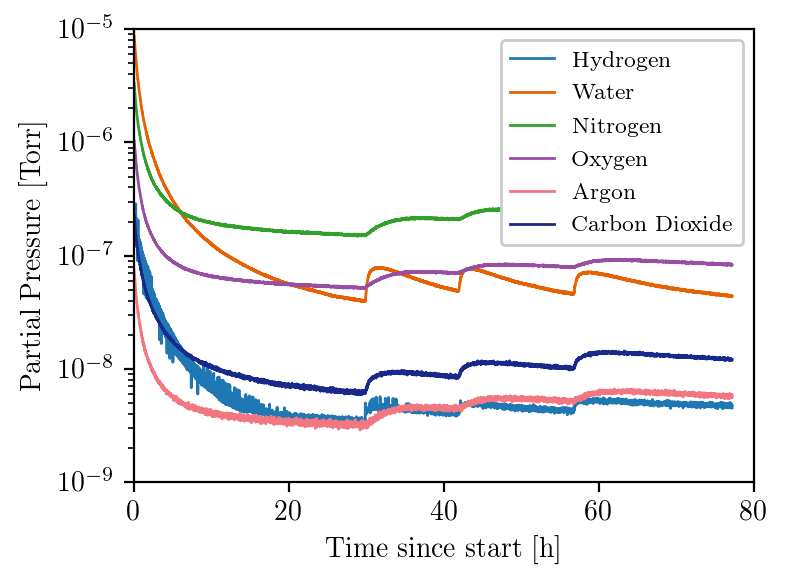

In [11]:
gases = [2,18,28,32,40,44]
labels = ['Hydrogen','Water','Nitrogen','Oxygen','Argon','Carbon Dioxide']

plt.figure()
# plt.xlim(0,np.max(delta_t/3600.0))
# plt.ylim(1e-10,1e-4)
plt.xlabel('Time since start [h]')
plt.ylabel('Partial Pressure [Torr]')

for i,gas in enumerate(gases):
    cut = np.where((amu<gas+0.5) & (amu>gas-0.5))
    pp = [np.max(x[cut]) for x in rga_scans]
    plt.plot(delta_t/3600.0, pp, label=labels[i], lw=1)

plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

In [12]:
def pick_gas(masses, elements):
    '''Returning a dictionary that includes the partial pressures from a certain gas'''
    rga_indiv_gas = {}
    for mass, element in zip(masses, elements):
        mask = np.where((amu<mass+0.5) & (amu>mass-0.5))
        rga_indiv_gas[element] = [np.max(rga[mask]) for rga in rga_scans]
    return rga_indiv_gas

In [13]:
o2pp = pick_gas([32], ['Oxygen'])['Oxygen']

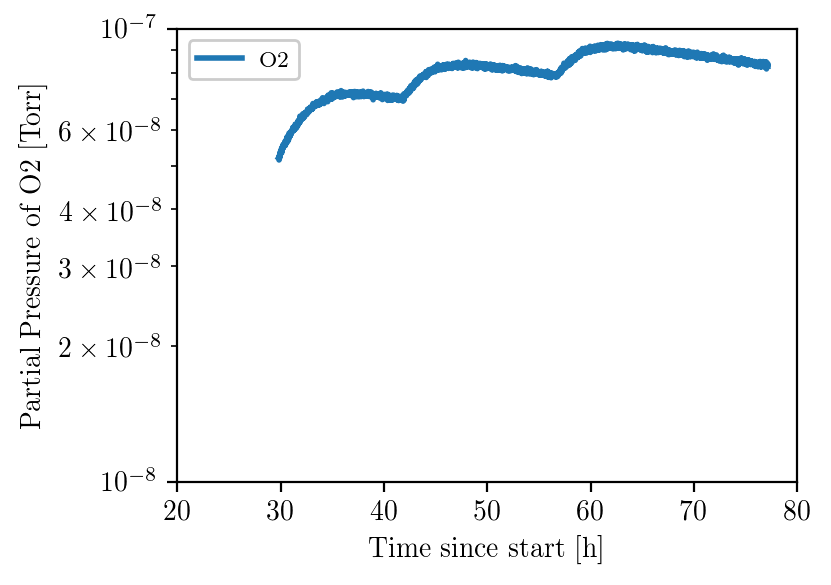

In [14]:
plt.figure()
plt.plot(delta_t[2376:]/3600.0, o2pp[2376:], label='O2')
plt.yscale('log')
plt.xlabel('Time since start [h]')
plt.ylabel('Partial Pressure of O2 [Torr]')
plt.legend()
plt.show()

In [161]:
def Laplace(x, temp, tau):
    laplace = np.exp(-x/(tau*3600))/np.sum(np.exp(-x/(tau*3600)))
    T = np.convolve(temp, laplace, mode='full')
    T[:500] = temp[:500]
    return T[:len(x)]

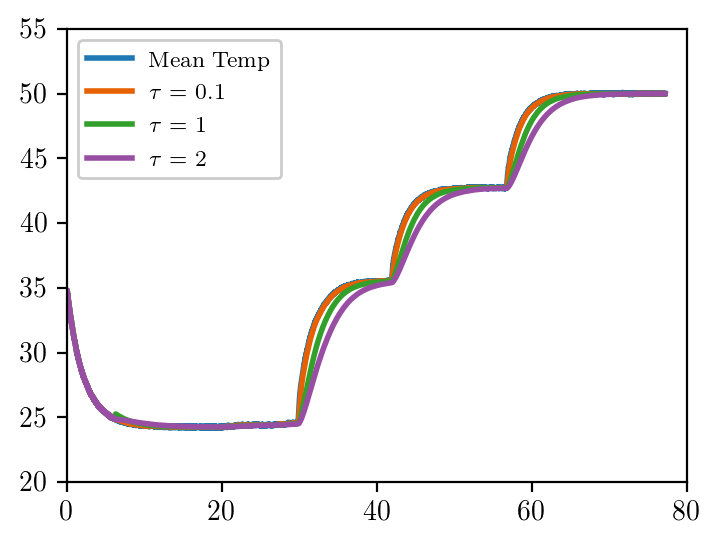

In [162]:
plt.figure()
plt.plot(tempdelta_t/3600, meantemp, label='Mean Temp')
for tau in [0.1, 1, 2]:
    T = Laplace(delta_t, meantemp, tau)
    plt.plot(tempdelta_t/3600, T, label=r'$\tau$ = {}'.format(tau))
plt.legend()
plt.show()

In [163]:
def fitfunction0(tT,a,b):
    return a*np.exp(-1.0*b/tT[0]) # A = c_0 * sqrt(D_0)

def fitfunction1(tT,A,b,tau):
    '''Performing the fit function with the Laplace transform on the temperature data
    tT is a list with element 0 denoting time and element 1 denoting temperature'''
    T = Laplace(tT[0], tT[1], tau)
    D = np.exp(-1.0*b/T)
    return A * np.sqrt(D/tT[0]) # A = c_0 * sqrt(D_0)

def fitfunction2(tT,A,b,B,tau):
    '''Performing the fit function with the Laplace transform on the temperature data
    tT is a list with element 0 denoting time and element 1 denoting temperature'''
    T = Laplace(tT[0], tT[1], tau)
    D = np.exp(-1.0*b/T)
    return A * np.sqrt(D/tT[0]) + B/tT[0] # A = c_0 * sqrt(D_0)

def fitfunction3(tT,A,b,B):
    '''Performing the fit function with the Laplace transform on the temperature data
    tT is a list with element 0 denoting time and element 1 denoting temperature'''
    D = np.exp(-1.0*b/tT[1])
    return A * np.sqrt(D/tT[0]) + B/tT[0] # A = c_0 * sqrt(D_0)

def fitfunction4(tT,A,b):
    '''Performing the fit function with the Laplace transform on the temperature data
    tT is a list with element 0 denoting time and element 1 denoting temperature'''
    D = np.exp(-1.0*b/tT[1])
    return A * np.sqrt(D/tT[0])

def fitfunction5(tT,A,b,tau,c):
    '''Performing the fit function with the Laplace transform on the temperature data
    tT is a list with element 0 denoting time and element 1 denoting temperature'''
    T = Laplace(tT[0], tT[1], tau)
    D = np.exp(-1.0*b/T)
    return A * np.sqrt(D/tT[0]) + A/tT[0] +  A*np.exp(-c/tT[0]) # A = c_0 * sqrt(D_0)

In [164]:
tt = np.linspace(delta_t.min(), delta_t.max(), len(delta_t))
itp = interp1d(delta_t, o2pp, kind='linear')
pp_sg = savgol_filter(itp(tt), 201, 3)

In [177]:
off = 2500
off1 = 300
off2 = 1900

In [178]:
popt0, pcov0 = curve_fit(fitfunction0, [delta_t[off1:off2], meantemp[off1:off2]], o2pp[off1:off2], p0=[1e-7,1e-2])
# popt0, pcov0 = curve_fit(fitfunction4, [delta_t[off1:off2], meantemp[off1:off2]], o2pp[off1:off2], p0=[1e-8,1e-8], maxfev=10000)

print('Performing fit 1...')
popt1, pcov1 = curve_fit(fitfunction1, [delta_t[off:], meantemp[off:]], o2pp[off:], p0=[1e-4,10,1])
print('Performing fit 2...')
popt2, pcov2 = curve_fit(fitfunction2, [delta_t[off:], meantemp[off:]], o2pp[off:], p0=[1e-4,100,1e-4,1])
print('Performing fit 3...')
popt3, pcov3 = curve_fit(fitfunction3, [delta_t[off:], meantemp[off:]], o2pp[off:], p0=[1e-4,100,1e-4])
print('Performing fit 4...')
popt4, pcov4 = curve_fit(fitfunction4, [delta_t[off:], meantemp[off:]], o2pp[off:], p0=[1e-4,100])
print('Performing fit 5...')
popt5, pcov5 = curve_fit(fitfunction5, [delta_t[off1:], meantemp[off1:]], o2pp[off1], p0=[popt0[0],popt2[1],popt2[3],popt0[1]], maxfev=10000)

Performing fit 1...
Performing fit 2...
Performing fit 3...
Performing fit 4...
Performing fit 5...


/gpfs/loomis/project/david_moore/aj487/conda_envs/py37s/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [179]:
print(popt0)
print(popt1)
print(popt2)
print(popt3)
print(popt4)
print(popt5)

[ 4.85042473e-08 -1.07452095e+04]
[1.53245074e-04 1.24944229e+02 7.03135504e-01]
[ 1.27078111e-04  9.61991765e+01 -2.35825895e-03  7.70508557e-01]
[ 1.29275594e-04  9.97825039e+01 -2.05544570e-03]
[1.53328643e-04 1.25682681e+02]
[ 1.05492096e-07  3.19978988e+04 -4.69147519e+02  1.00002686e+00]


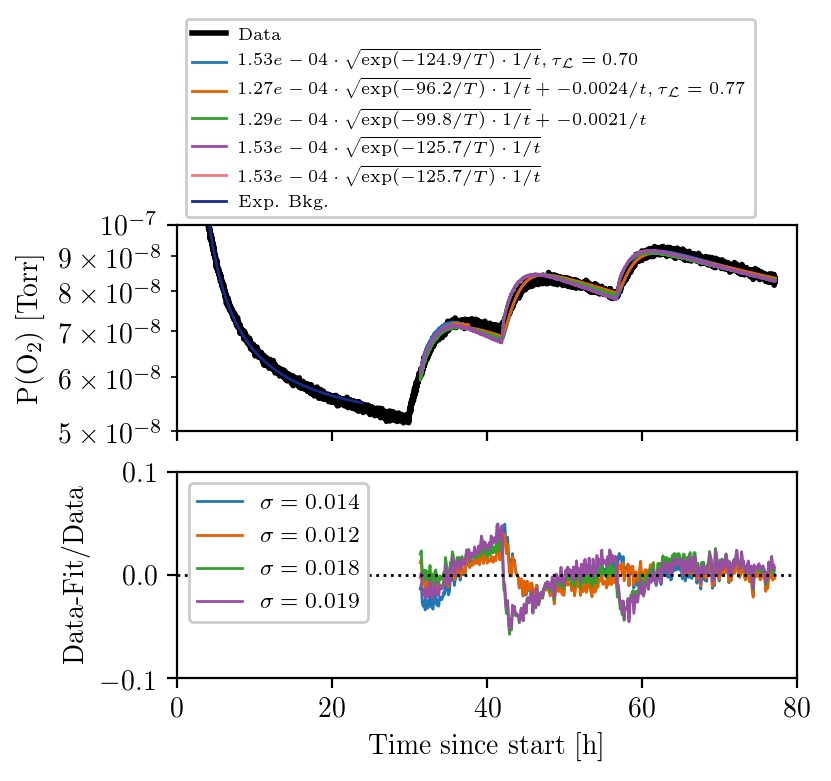

In [180]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].set_ylim(5e-8, 1e-7)
# ax[0].set_ylim(5e-8, 1e-6)
ax[0].plot(delta_t/3600, o2pp, label='Data', color='k')

ax[0].plot(delta_t[off:]/3600, fitfunction1([delta_t[off:],meantemp[off:]], *popt1), lw=1, label='${:.2e}\cdot \sqrt{{\exp(-{:.1f}/T)\cdot 1/t}}, \\tau_{{\mathcal{{L}}}} = {:.2f}$'.format(*popt1))
ax[0].plot(delta_t[off:]/3600, fitfunction2([delta_t[off:],meantemp[off:]], *popt2), lw=1, label='${:.2e}\cdot \sqrt{{\exp(-{:.1f}/T)\cdot 1/t}} + {:.4f}/t, \\tau_{{\mathcal{{L}}}} = {:.2f}$'.format(*popt2))
ax[0].plot(delta_t[off:]/3600, fitfunction3([delta_t[off:],meantemp[off:]], *popt3), lw=1, label='${:.2e}\cdot \sqrt{{\exp(-{:.1f}/T)\cdot 1/t}} + {:.4f}/t$'.format(*popt3))
ax[0].plot(delta_t[off:]/3600, fitfunction4([delta_t[off:],meantemp[off:]], *popt4), lw=1, label='${:.2e}\cdot \sqrt{{\exp(-{:.1f}/T)\cdot 1/t}}$'.format(*popt4))
ax[0].plot(delta_t[off:]/3600, fitfunction5([delta_t[off:],meantemp[off:]], *popt5), lw=1, label='${:.2e}\cdot \sqrt{{\exp(-{:.1f}/T)\cdot 1/t}}$'.format(*popt4))
ax[0].plot(delta_t[off1:off2]/3600, fitfunction0([delta_t[off1:off2],meantemp[off1:off2]], *popt0), lw=1, label='Exp. Bkg.')

ax[1].set_xlabel('Time since start [h]')
ax[0].set_ylabel('P(O$_2$) [Torr]')
ax[0].set_yscale('log')
ax[0].legend(bbox_to_anchor=(0., 1.), loc='lower left', fontsize=6, ncol=1)

res_t = delta_t[off:]/3600
res1 = (o2pp[off:]-fitfunction1([delta_t[off:],meantemp[off:]], *popt1))/o2pp[off:]
res2 = (o2pp[off:]-fitfunction2([delta_t[off:],meantemp[off:]], *popt2))/o2pp[off:]
res3 = (o2pp[off:]-fitfunction3([delta_t[off:],meantemp[off:]], *popt3))/o2pp[off:]
res4 = (o2pp[off:]-fitfunction4([delta_t[off:],meantemp[off:]], *popt4))/o2pp[off:]
ax[1].plot(res_t[::10], res1[::10], lw=1, label='$\sigma={:.3f}$'.format(np.std(res1)))
ax[1].plot(res_t[::10], res2[::10], lw=1, label='$\sigma={:.3f}$'.format(np.std(res2)))
ax[1].plot(res_t[::10], res3[::10], lw=1, label='$\sigma={:.3f}$'.format(np.std(res3)))
ax[1].plot(res_t[::10], res4[::10], lw=1, label='$\sigma={:.3f}$'.format(np.std(res4)))
ax[1].set_ylabel('Data-Fit/Data')
ax[1].set_ylim(-0.1,0.1)
ax[1].hlines(y=0, xmin=0, xmax=80, ls=':', lw=1, zorder=4)
ax[1].legend(loc='upper left')

plt.show()